In [1]:
import torch
# from encoder.encoders import DistributionEncoderTx
from encoder.wormhole_encoder import WormholeEncoder
from generator.wormhole import WormholeGenerator
from datasets.mnist import MNISTDataset
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mixer.mixer import SetMixer

from geomloss import SamplesLoss

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [15]:
dataset = MNISTDataset(set_size=100, n_sets=10**3, n_classes=3)
mixer = SetMixer(k=3)

In [16]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=mixer.collate_fn
)

In [17]:
in_dim = 28*28
latent_dim = 64
hidden_dim = 128
set_size = dataset.set_size
device = 'cuda'

enc = WormholeEncoder(dataset.data[0][0].shape, latent_dim, hidden_dim, set_size)
gen = WormholeGenerator(latent_dim, in_dim, hidden_dim, set_size)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(gen.parameters()), lr=1e-4)
enc.to(device)
gen.to(device)

WormholeGenerator(
  (model): DistributionDecoderTx(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): SELU()
      (2): SelfAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (3): Linear(in_features=128, out_features=784, bias=True)
    )
    (multiplier): Linear(in_features=64, out_features=6400, bias=True)
  )
  (sinkhorn): SamplesLoss()
)

In [18]:
for epoch in range(10):
    for idx,batch in enumerate(dataloader):
        
        samples = batch['samples'].to(device)
        latent = enc(samples)
        loss = gen.loss(samples.view(-1, *samples.shape[2:]), latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print(f"epoch {epoch} batch {idx}: loss {loss.item()}")

epoch 0 batch 0: loss 566.4932250976562
epoch 0 batch 100: loss 271.1984558105469
epoch 1 batch 0: loss 261.41619873046875
epoch 1 batch 100: loss 70.91371154785156
epoch 2 batch 0: loss 77.25043487548828
epoch 2 batch 100: loss 68.92066955566406
epoch 3 batch 0: loss 60.862884521484375
epoch 3 batch 100: loss 38.98191833496094
epoch 4 batch 0: loss 39.306739807128906
epoch 4 batch 100: loss 87.89033508300781
epoch 5 batch 0: loss 42.05760192871094
epoch 5 batch 100: loss 119.08309936523438
epoch 6 batch 0: loss 105.60018920898438
epoch 6 batch 100: loss 32.51258087158203
epoch 7 batch 0: loss 57.598365783691406
epoch 7 batch 100: loss 44.79024124145508
epoch 8 batch 0: loss 60.9937858581543
epoch 8 batch 100: loss 64.81698608398438
epoch 9 batch 0: loss 32.75112533569336
epoch 9 batch 100: loss 29.05989646911621


In [13]:
enc.eval()
gen.eval()

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
) # default collate now!!

Zs = []
labels = []
with torch.no_grad():
    for idx,batch in enumerate(dataloader):
        samples = batch['samples'].flatten(start_dim=2).to(device)
        latent = enc(samples)
        Zs += latent.cpu().tolist()
        labels += [b.item() for b in batch['metadata'].cpu()]
        

In [8]:
# t = TSNE(n_components=2, random_state=0)
# Zs = np.array(Zs)
# Zs = t.fit_transform(Zs)

In [9]:
# sns.scatterplot(x=Zs[:, 0], y=Zs[:, 1], hue=labels, 
#                 palette=sns.color_palette("hsv", 10))

[1, 1, 2, 2, 1, 0, 2, 0]


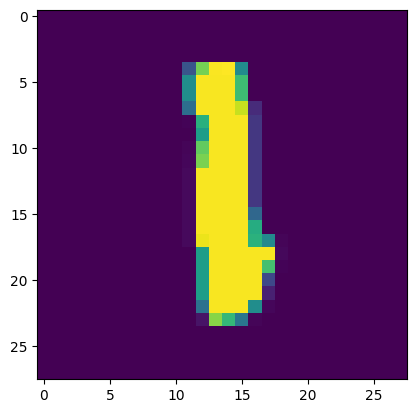

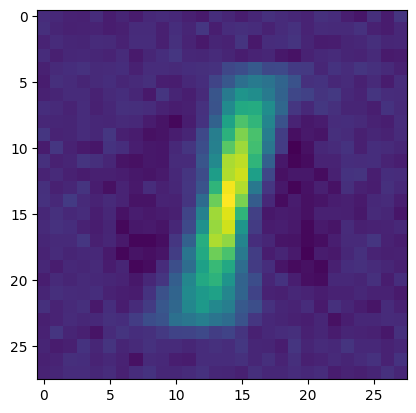

In [20]:
with torch.no_grad():
    for idx,batch in enumerate(dataloader):
        samples = batch['samples'].to(device)
        latent = enc(samples)
        img = gen(latent).reshape(8, set_size, 28, 28)
        metadata = [b.item() for b in batch['metadata'].cpu()]

        print(metadata)

        plt.imshow(samples[1][0].cpu().reshape(28, 28))
        plt.show()

        plt.imshow(img[1][0].cpu())
        break

In [ ]:
import sys
import os
import hydra
from omegaconf import OmegaConf

# add parent directory to path
sys.path.append(os.path.abspath(os.path.join('..')))

# initialize hydra

In [ ]:
hydra.initialize(config_path="config", version_base="1.1")

hydra.initialize()

In [ ]:
cfg = hydra.compose(
    config_name='config',
    overrides=["experiment=mnist_multinomial",
                "encoder=wormhole_encoder",
                "generator=ddpm"]
)

In [ ]:
encoder = hydra.utils.instantiate(cfg.encoder)
generator = hydra.utils.instantiate(cfg.generator)

In [ ]:
cfg.generator

{'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}